In [91]:
import tensorflow as tf
import keras
from keras_vggface.vggface import VGGFace
from matplotlib import pyplot as plt
import datetime
import cv2
import PIL
from tensorflow.keras.models import load_model
import numpy as np

#### if encounter error "ModuleNotFoundError: No module named 'keras.engine.topology'"

locate keras_vggface/models.py for example ../../../miniconda3/envs/ML/lib/python3.9/site-packages/keras_vggface/models.py

changing the import from

from keras.engine.topology import get_source_inputs

to

from keras.utils.layer_utils import get_source_inputs

#### GPU Check

In [2]:
tf.config.list_physical_devices('GPU')

2023-09-18 10:32:23.966143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 10:32:23.984833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 10:32:23.985009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [92]:
train_dataset = keras.utils.image_dataset_from_directory('datasets_VGG',
                                                         validation_split = 0.1,
                                                         subset="training",
                                                         seed = 69420,
                                                         batch_size=16,
                                                         image_size=(224,224))

Found 1792 files belonging to 4 classes.
Using 1613 files for training.


In [93]:
valid_dataset = keras.utils.image_dataset_from_directory('datasets_VGG',
                                                         validation_split = 0.1,
                                                         subset="validation",
                                                         seed = 69420,
                                                         batch_size=16,
                                                         image_size=(224,224))

Found 1792 files belonging to 4 classes.
Using 179 files for validation.


In [5]:
valid_dataset_unbatch = valid_dataset.unbatch()
valid_imgs = list(valid_dataset_unbatch.map(lambda x, y: x))
valid_labels= list(valid_dataset_unbatch.map(lambda x, y: y))

In [6]:
data_aug = keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [7]:
vggface_resnet_base = VGGFace(model='resnet50')

In [8]:
print('Inputs: %s' % vggface_resnet_base.inputs)
print('Outputs: %s' % vggface_resnet_base.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


In [9]:
from keras.layers import Flatten, Dense, Input

In [10]:
vggface_resnet_base.trainable = False
last_layer = vggface_resnet_base.get_layer('avg_pool').output

inputs = tf.keras.Input(shape=(224,224,3))

x = data_aug(inputs)
x = vggface_resnet_base(x)
x = Flatten(name='flatten')(x)

out = Dense(4, name='classifier')(x)
custom_model = keras.Model(inputs, out)

In [11]:
base_lr = 0.001

custom_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_lr),
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [12]:
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vggface_resnet50 (Functiona  (None, 8631)             41246071  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 8631)              0         
                                                                 
 classifier (Dense)          (None, 4)                 34528     
                                                                 
Total params: 41,280,599
Trainable params: 34,528
Non-trainable params: 41,246,071
____________________________________________

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=5)

In [14]:
his = custom_model.fit(train_dataset, validation_data=valid_dataset, 
                       epochs=300, callbacks=[early_stopping])

Epoch 1/300


2023-09-18 10:32:28.656022: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-09-18 10:32:28.720008: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-18 10:32:28.720442: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-18 10:32:28.720464: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-09-18 10:32:28.720913: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-18 10:32:28.720952: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  4/101 [>.............................] - ETA: 5s - loss: 1.3842 - accuracy: 0.3906

2023-09-18 10:32:29.186549: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


101/101 [==============================] - 11s 70ms/step - loss: 1.3586 - accuracy: 0.4098 - val_loss: 1.3154 - val_accuracy: 0.4246
Epoch 2/300
101/101 [==============================] - 6s 58ms/step - loss: 1.3130 - accuracy: 0.4117 - val_loss: 1.2607 - val_accuracy: 0.4190
Epoch 3/300
101/101 [==============================] - 6s 59ms/step - loss: 1.2757 - accuracy: 0.4148 - val_loss: 1.2116 - val_accuracy: 0.4246
Epoch 4/300
101/101 [==============================] - 6s 58ms/step - loss: 1.2446 - accuracy: 0.4284 - val_loss: 1.1668 - val_accuracy: 0.4358
Epoch 5/300
101/101 [==============================] - 6s 58ms/step - loss: 1.2174 - accuracy: 0.4433 - val_loss: 1.1260 - val_accuracy: 0.4804
Epoch 6/300
101/101 [==============================] - 6s 59ms/step - loss: 1.1920 - accuracy: 0.4724 - val_loss: 1.0884 - val_accuracy: 0.5642
Epoch 7/300
101/101 [==============================] - 6s 58ms/step - loss: 1.1645 - accuracy: 0.5152 - val_loss: 1.0530 - val_accuracy: 0.6648
Epo

Text(0, 0.5, 'Loss')

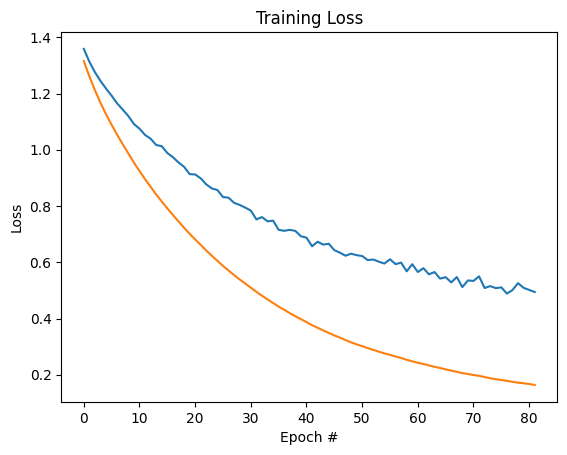

In [15]:
plt.figure()
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

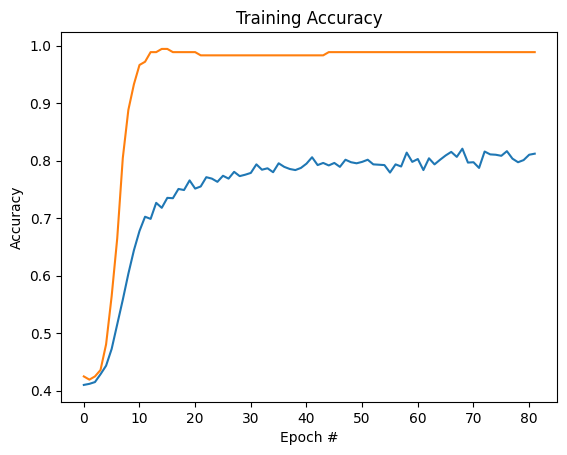

In [16]:
plt.figure()
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')

In [17]:
prob_model = keras.Sequential([custom_model,
                               tf.keras.layers.Softmax()
                               ])

In [18]:
time_stamp = datetime.datetime.now()
time_stamp.strftime("%d_%b_%y_%H_%M_%S")
prob_model.save(f"model/model_{time_stamp}.tf")

INFO:tensorflow:Assets written to: model/model_2023-09-18 10:40:38.841441.tf/assets


INFO:tensorflow:Assets written to: model/model_2023-09-18 10:40:38.841441.tf/assets


In [94]:
model = load_model('model/model_2023-09-18 10:40:38.841441.tf')